# Preliminaries

## Dataset

In this set of exercises we will use the same dataset as from [week 3](week_3.ipynb). 


As before, we provide the data already curated in the following two files:

`RNA_expression_curated.csv`: [148 cell lines , 238 genes]

`drug_response_curated.csv`: [148 cell lines , YM155 drug]

The curated data can be read as `pandas` `DataFrame` in the following way:

In [1]:
import pandas as pd

gene_expression = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0)
drug_response = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0)

The goal of the exercises is to train support vector machine (SVM) and random forests classifiers on this dataset and explore and learn about their hyperparameters. 

## Tools

The `scikit-learn` library provides the required tools for support vector machines, as well as for random forest algorithms.

In [2]:
from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
#from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import classification_report

Before proceeding, look up the documentation of the imported functions and read about their basic functionality. Below, we list some important parameters of SVMs and random forests that can be tuned during training.

#### Support Vector Machines (SVM)

`C`: error term.

`kernel`: similarity function ('linear', 'poly', 'sigmoid' or 'rbf')

`gamma`: kernel coef. for 'rbf', 'poly' and 'sigmoid' kernels. It can be thought of as the ‘spread’ of the kernel and therefore the decision region.

`degree`: degree for the 'poly' kernel.

`coef0`: independt term in the 'poly' and 'sigmoid' kernels


#### Random Forests

`n_estimators`: number of trees in our random forest.

`max_depth`: maximum number of levels in each decision tree

`max_features`: maximum number of features to consider per split in an individual tree.

`min_sample_leaf`: minimum number of data points per leaf node

`min_samples_split`: minimum number of data points placed in a node before the node is split

`oob_score`: the out-of-bag (OOB) error is the average error for each observation calculated using predictions from the trees that do not contain that observation in their respective bootstrap sample. Set this parameter to true.

`bootstrap`: method for sampling data points (with or without replacement). Set this parameter to true.

`criterion`: function used to measure the quality of the split (e.g. 'entropy' or 'gini')

# Exercises

## Support vector machines

The  `make_blobs` and `make_circles` functions can be used to generate linearly and not linearly separable toy datasets. 

In [3]:
# data generation: linearly separable
X, Y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

The following code illustrates how to train a linear SVM classifier and plot the data points, the separating hyperplane, the support vectors and the margins that pass through them (considering the training data)

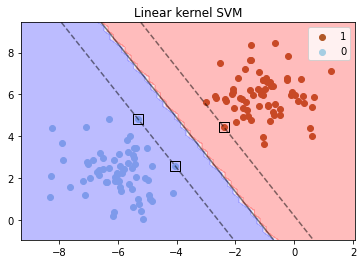

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# build the model
model = svm.SVC(kernel='linear', random_state=33)
model.fit(X_train, Y_train)

# create plot
fig, ax = plt.subplots()

# get colors from qualitative colormap 'Paired'
cmap = plt.cm.get_cmap('Paired')

# plot data points
ax.scatter(X_train.iloc[Y_train == 1, 0], X_train.iloc[Y_train == 1, 1],
           c=[cmap(11)], label='1')
ax.scatter(X_train.iloc[Y_train == 0, 0], X_train.iloc[Y_train == 0, 1],
           c=[cmap(0)], label='0')
ax.legend(loc='best')

# plot the decision function
# create grid to evaluate model
x1_min, x1_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
x2_min, x2_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1

XX, YY = np.meshgrid(np.arange(x1_min, x1_max, .2),
                     np.arange(x2_min, x2_max, .2))

xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])

# Establish the class for each point in the contour
Z = model.predict(xy).reshape(XX.shape)

# Visualization of the contour
ax.contourf(XX, YY, Z, cmap='bwr', alpha=0.3)

# plot support vectors, whose are responsible for building the margins
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', marker='s')

ax.axis([x1_min, x1_max, x2_min, x2_max])
plt.axis('tight')
plt.title('Linear kernel SVM')
plt.show()

Train a radial basis function (RBF) SVM classifier with `gamma=0.5` and plot the results in the same way.

In [5]:
# data generation: not linearly separable
X, Y = make_circles(n_samples=200, noise=0.05, random_state=1234)
X = pd.DataFrame(X, columns=['x1', 'x2'])

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=333)

<p><font color='#770a0a'>When should a RBF kernel be used over a linear kernel? Motivate your answer.</font></p>

<p><font color='#770a0a'>Do we need to normalize the data before using a kernel function? Motivate your answer.
</font></p>

## Predicting drug response on cell lines from gene expression data with SVMs

Explore the hyper-parameter space of an SVM classifier with cross-validation for the Genomics of Drug Sensitivity in Cancer (GDSC) dataset. The`GridSearchCV` function can be used to specify a grid of parameter values with the `param_grid` parameter.

Calculate the precision of your predictions, and compare your calculations with the results of `classification_report`, which displays many classification metrics.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
#from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import classification_report, precision_score
from sklearn.preprocessing import StandardScaler

X = pd.read_csv("./data/RNA_expression_curated.csv", sep=',', header=0, index_col=0) # gene expression
y = pd.read_csv("./data/drug_response_curated.csv", sep=',', header=0, index_col=0) # drug response

# splitting data into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15, random_state = 0)

# Return 1-D array
Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

# Based on the IC50 metric, cells can be classified as sensitive or resistant. 
# The classification is done by computing the 𝑧 -score across all cell lines in the GDSC for each drug, and considering 
# as sensitive the ones with 𝑧 -score < 0 and resistant the ones with 𝑧 -score > 0.
Y_train = list(map(lambda value: 1 if value > 0 else 0, Y_train))
Y_test = list(map(lambda value: 1 if value > 0 else 0, Y_test))

# We now create a processing pipeline that includes the scaling (in order to transform all features to a have a zero mean 
# and unit variance) and the SVM models in a sequence.
pipelineSVC = Pipeline([
                 ("scaler", StandardScaler()),
                 ("model", svm.SVC())
                ])

# Hyperparameters
C = 10.**np.arange(-4, 4)      # error term
gamma = 10.**np.arange(-4, 1)  # kernel coef. for 'rbf', 'poly' and 'sigmoid' kernels
degree = [1, 2, 3, 4, 5, 6]    # degree for the 'poly' kernel
coef0 = [-10, -1, 0, 1, 10]    # independent term in the 'poly' and 'sigmoid' kernels

# Create the parameter grid
param_grid_SVC = [{'model__kernel': ['rbf'], 'model__C': C, 'model__gamma': gamma}, 
                  {'model__kernel': ['poly'], 'model__C': C, 'model__gamma': gamma, 'model__degree': degree, 
                   'model__coef0': coef0},
                  {'model__kernel': ['sigmoid'], 'model__C': C, 'model__gamma': gamma, 'model__coef0': coef0}, 
                  {'model__kernel': ['linear'], 'model__C': C}]

# cv = 10: cross-validation with 10 folds
gridSVC = GridSearchCV(estimator=pipelineSVC, verbose = 2, param_grid = param_grid_SVC, refit=True, cv = 10, scoring='f1', n_jobs = -1)
gridSVC.fit(X_train,Y_train)
print("Best parameters: \n {}".format(gridSVC.best_params_))

Fitting 10 folds for each of 1448 candidates, totalling 14480 fits
Best parameters: 
 {'model__C': 1000.0, 'model__coef0': 1, 'model__gamma': 0.0001, 'model__kernel': 'sigmoid'}


The score method chosen was the f1-score, because it takes both false positives and false negatives into account, and it is more useful than accuracy when the class distribution is uneven (as it happens in this case). 

In [7]:
Y_test_pred = gridSVC.predict(X_test)
print('Precision = \n {}'.format(precision_score(Y_test, Y_test_pred)))
print('\n{}'.format(classification_report(Y_test, Y_test_pred)))

Precision = 
 0.6666666666666666

              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.67      0.80      0.73         5

    accuracy                           0.87        23
   macro avg       0.80      0.84      0.82        23
weighted avg       0.88      0.87      0.87        23



The precision computed with "precision_score" has the same outcome as the precision computed with "classification_report" for the class with positive label (1). We can also see that all classification metrics have higher results for the targets with classification 0 than for targets with classification 1.
Computing the precision_score is the same as calculating the ratio $\frac{tp}{tp+fp}$, as seen below, where tp is the number of true positives and fp the number of false positives.

In [8]:
def precision(real, predicted):
    tp = 0
    fp = 0
    for i in range(len(real)):
        if real[i] == 1 and predicted[i] == 1:
            tp = tp +1
        elif real[i] == 0 and predicted[i] == 1:
            fp = fp + 1
    return tp/(tp+fp)

precision(Y_test, Y_test_pred)

0.6666666666666666

## Random forests

Follow the same steps as for SVM. Compare the two algorithms and report which one has better performance.

In [9]:
# Create the processing pipeline including the scaling and the random forests model
pipelineRF = Pipeline([
                 ("scaler", StandardScaler()),
                 ("model", RandomForestClassifier(bootstrap = True, oob_score = True))],
                  verbose=True)

# Define the parameters for the grid search
param_grid = {'model__n_estimators': np.linspace(200, 400, 5).astype(int),
              'model__criterion': ['gini', 'entropy'],
              'model__max_depth': np.linspace(5, 15, 5).astype(int),
              'model__max_features': np.linspace(40, 100, 5).astype(int),
              'model__min_samples_leaf': np.linspace(3, 7, 5).astype(int),
              'model__min_samples_split': np.linspace(3, 7, 5).astype(int)}

# Estimator values between linspace were chosen by running the model a couple of times
# And finetuning these parameters to values close to the best parameters found in the previous runs

# Perform the grid search of the parameters with the default 5-fold cross validation
grid_search = GridSearchCV(estimator = pipelineRF,
                           param_grid = param_grid,
                           scoring = 'f1',
                           n_jobs = -1,
                           verbose = 2) 

# Fit the model
grid_search.fit(X_train, Y_train)

# Show the best parameters of the model
print('Best parameters: {}'.format(grid_search.best_params_))

# Use these parameters to make predictions
Y_pred = grid_search.best_estimator_.predict(X_test)

Fitting 5 folds for each of 6250 candidates, totalling 31250 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.7s
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 15, 'model__max_features': 70, 'model__min_samples_leaf': 3, 'model__min_samples_split': 4, 'model__n_estimators': 200}


In [10]:
#___Calculate the precision of the random forests, and compare with the performance of the SVM___

print('Precision = \n {}'.format(precision_score(Y_test, Y_pred)))
print('\n{}'.format(classification_report(Y_test, Y_pred)))

precision(Y_test, Y_pred)

Precision = 
 0.6666666666666666

              precision    recall  f1-score   support

           0       0.85      0.94      0.89        18
           1       0.67      0.40      0.50         5

    accuracy                           0.83        23
   macro avg       0.76      0.67      0.70        23
weighted avg       0.81      0.83      0.81        23



0.6666666666666666

***Question***: Compare the SVM algorithm with the random forests, and report which one has better performance. 

***Answer***: ‘Support’ shows how often each class is present in the targets of the test set. What is noticeable is that class 0 (sensitive cell lines) occurs far more often in the test set than class 1 (resistant cell lines). We want to take this label imbalance into account when looking at the performance of the models. Therefore, we look at the weighted average instead of the macro average of the models.


What metrics is best to evaluate the performance of the model, depends on the goal of the model. The precision is the ratio of tp / (tp + fp). We want this number to be high, when the consequences of false positives are high. For example on class 1 on this dataset false positive would mean that the cell line is predicted to be resistant to a drug (class 1), while in reality it is sensitive to the drug (class 0). This could result in wrongly not treating the patient with the drug. When we want to avoid this mistake, we should choose the model with the highest precision. Here the SVM has the highest precision of 0.88, while the RF (random forests) has the lower precision of 0.81.


The recall is the ratio of tp / (tp + fn). This metrics should be high when the consequences of a false negative are high. Again as example on class 1 on this dataset false negative would mean that the cell line is predicted to be sensitive to a drug (class 0), while in reality it is resistant to a drug (class 1). This could result in wrongly giving a patient a drug which has no effect. When it is important to avoid this mistake, we should choose the model with the highest recall. Here the SVM has the highest recall of 0.87, while the RF has the lowest recall of 0.83.


The F1 score combines both the precision and the recall into one score, in which both measures contribute equal to this F1 score. For the SVM model the weighted average F1 score is 0.87, whereas for the RF model the weighted average F1 score is 0.81. A F1 score of 1 is best, while a F1 score of 0 is worst. Thus, the SVM model has on overall the best performance. Evaluating the F1 score for these two models was not strictly necessary, since the SVM already had a better precision and recall performance as compared to the RF.  

The random forests classifiers allows to perform feature selection. Evaluate the importance of features extracting the top 50 informative features. A bar plot (`plt.bar()`) can be a useful tool to visualize this. 

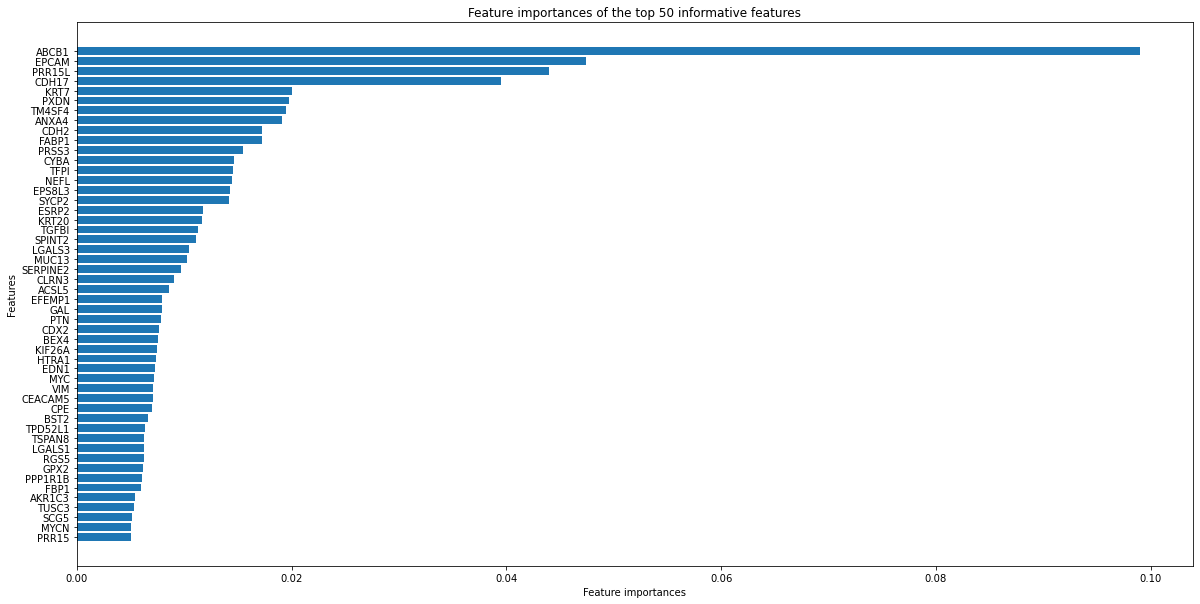

In [11]:
#___ Visualise the top 50 informative features___

# Get the feature importances and their labels from the grid search
feature_importances = grid_search.best_estimator_._final_estimator.feature_importances_
labels = gene_expression.columns
labelled_importances = pd.Series(feature_importances, labels)

# Rearange the importances from largest to smallest
rearanged_importances = labelled_importances.sort_values(ascending = False)

# Get the top 50 informative features
top50 = rearanged_importances[0:50]

# Rearange the top 50 feature importances from smallest to largest
rearanged_top50 = top50.sort_values(ascending = True)

plt.figure(figsize=(20,10))
plt.barh(rearanged_top50.index, rearanged_top50)
plt.title('Feature importances of the top 50 informative features')
plt.xlabel('Feature importances')
plt.ylabel('Features')
plt.show()

## Biomedical applications

Driven by technological advances, there has recently been a dramatic increase in availability of biomedical data. Machine learning approaches are well suited to take advantage of this data and have been widely applied to many areas of biology. 

Example of these applications are genome annotation, biomarker identification, systems biology, genome data analysis, protein  function  prediction, protein  structure prediction, protein localization prediction, identification of protein interactions and drug discovery.

SVM and RF methods are among the most popular machine learning methods applied in bioinformatics or computational biology.

Perform a literature search and find a biomedical study in which SVM or RF is applied to obtain certain insights. <p><font color='#770a0a'>Explain the motivation behind using that specific algorithm in the study.
</font></p>